# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">4. Level 1 Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |



---

### **4. Level 1 Classification Notebook**
**Description:**
In this notebook, we will build and evaluate the **Level 1 Binary Classification model**, which separates the data into:
- Cases belonging to the two most common classes (e.g., **2 - NON-COMP** and **4 - TEMPORARY**).
- Cases classified as “**Other**” (all remaining classes).

Key steps include:
- Loading the **preprocessed dataset** created in Notebook 1.
- **Feature selection:** Identify features most relevant to this binary classification task.
- **Model training:** Train a binary classification model to distinguish between the "Common" and "Other" categories.
- **Evaluation:** Assess the performance of the Level 1 model using metrics like accuracy, precision, and recall.
- **Output:** Save predictions to pass data into the next stages (Level 2 Binary and Level 2 Multi-Class models).

This notebook ensures that data is efficiently routed into the appropriate paths for the subsequent levels.

---


<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [4.1. Preparing the Data](#section_4_1)  
    * [4.2. Numerical Features](#section_4_2) 
        * [4.2.1. LASSO Regression](#section_4_2_1)
        * [4.2.2. Recursive Feature Elimination - RFE](#section_4_2_2)
        * [4.2.3. Feature Importance - Decision Tree](#section_4_2_3)
        * [4.2.4. Feature Importance - Random Forest](#section_4_2_4)
    * [4.3. Categorical Features](#section_4_3)
        * [4.3.1. $\chi ^2$ Test for Independence](#section_4_3_1)
        * [4.3.2. Mutual Information Criterion (MIC)](#section_4_3_2)
    * [4.4. Final Features](#section_4_4)
* [5. Modelling](#chapter5)
    * [5.1. Logistic Regression](#section_5_1)  
    * [5.2. KNN](#section_5_2) 
    * [5.3. Random Forest](#section_5_3)  
    * [5.4. Decision Trees](#section_5_4) 
    * [5.5. Gradient Boosting](#section_5_5)  
    * [5.6. Voting Classifier](#section_5_6)  
    * [5.7. Ensemble Method Using Weighted Probabilities](#section_5_7)
    * [5.8. Summary of Models](#section_5_8)  
* [6. Loading the results](#chapter6)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>
[Back to ToC](#toc)<br>


In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier


# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')




from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances
from utils import compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics



In this topic we will also import the pre-saved feature categories dictionary from Notebook 3, ensuring consistency in feature grouping for feature selection and modeling.

In [3]:
# Load the feature categories dictionary
feature_categories_file = "feature_categories.pkl"
with open(feature_categories_file, "rb") as file:
    feature_categories = pickle.load(file)

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

Now that we preprocessed the dataset in notebook 3. we will upload those datasets

In [4]:
# Import the datasets
X_train = pd.read_csv("../processed_datasets/X_train_model.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_model.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../processed_datasets/df_test_model.csv", index_col="Claim Identifier")

In [5]:
X_train.head(5)

,Age at Injury,IME-4 Count,Agreement Reached,Income_Category,Accident_Quarter,Accident_Year,Accident Day,Age Group,promptness_category,promptness_C2_category,...,Industry Code_freq,County of Injury_freq,District Name_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier Name_freq,Body_Part_Category_freq,Injury_Nature_Category_freq,Carrier Type Merged_freq
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6099734,67,4.0,0.0,1,3,2022,3,1,3,3,...,34856,34897,216798,9648,44601,38469,11544,96343,404174,228492
5796182,30,0.0,0.0,1,3,2021,5,2,7,7,...,34856,13901,68763,6081,88312,15038,11163,96343,404174,228492
6128237,58,0.0,0.0,0,4,2022,3,0,7,7,...,2362,636,17442,11777,13917,6521,14012,80866,404174,228492
5394501,55,0.0,0.0,3,3,2019,5,0,1,1,...,29868,31684,216798,13345,44601,18172,5841,37241,404174,42169
5452763,25,0.0,0.0,2,1,2020,2,3,7,7,...,35389,10965,68763,29680,122811,15042,88862,142559,404174,88862


In [6]:
# Load the arrays
y_train = np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)
y_val =  np.load("../processed_datasets/y_val_preprocessed.npy", allow_pickle=True)

# 3. Setting the Target <a class="anchor" id="chapter3"></a>

[Back to ToC](#toc)<br>


In this section, we will analyze the distribution of the target variable to better understand its composition. This step is crucial for determining how to split the target into the two categories needed for the first level of the hierarchical classification: identifying the most common classes versus the "Other" category.

In [7]:
# Convert to Pandas Series and get value counts
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

2. NON-COMP        232862
4. TEMPORARY       118805
3. MED ONLY         55125
5. PPD SCH LOSS     38624
1. CANCELLED         9980
6. PPD NSL           3369
8. DEATH              376
7. PTD                 78
dtype: int64

In [8]:
# Convert to Pandas Series and get value counts
y_val_series = pd.Series(y_val)
y_val_series.value_counts()

2. NON-COMP        58216
4. TEMPORARY       29702
3. MED ONLY        13781
5. PPD SCH LOSS     9656
1. CANCELLED        2495
6. PPD NSL           842
8. DEATH              94
7. PTD                19
dtype: int64

In [9]:
# Create a mapping where 2. NON-COMP and 4. TEMPORARY are mapped to new targets
def map_to_majority_minority(y):
    """
    Map the original targets to new categories:
    - '2. NON-COMP' and '4. TEMPORARY' -> 'Majority Target'
    - All other classes -> 'Minority Target'
    """
    return np.where(np.isin(y, ['2. NON-COMP', '4. TEMPORARY']), 'Majority Target', 'Minority Target')

# Apply the mapping to y_train and y_val
y_train_mapped = map_to_majority_minority(y_train)
y_val_mapped = map_to_majority_minority(y_val)

# Ensure the original y_train and y_val are preserved
print("Original y_train classes:", np.unique(y_train))
print("Mapped y_train classes:", np.unique(y_train_mapped))
print("Mapped y_val classes:", np.unique(y_val_mapped))

Original y_train classes: ['1. CANCELLED' '2. NON-COMP' '3. MED ONLY' '4. TEMPORARY'
 '5. PPD SCH LOSS' '6. PPD NSL' '7. PTD' '8. DEATH']
Mapped y_train classes: ['Majority Target' 'Minority Target']
Mapped y_val classes: ['Majority Target' 'Minority Target']


In [10]:
# Convert to Pandas Series and get value counts
y_train_new_series = pd.Series(y_train_mapped)
y_train_new_series.value_counts()

Majority Target    351667
Minority Target    107552
dtype: int64

In [11]:
# Convert to Pandas Series and get value counts
y_val_new_series = pd.Series(y_val_mapped)
y_val_new_series.value_counts()

Majority Target    87918
Minority Target    26887
dtype: int64

**Encoding the Target**

In [12]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode y_train_new and y_val_new
y_train_encoded = encoder.fit_transform(y_train_mapped)  # Fit and transform on y_train_mapped
y_val_encoded = encoder.transform(y_val_mapped)  # Only transform on y_train_mapped

In [13]:
# Verify that the target is encoded 
print(f'y_train encoded: {y_train_encoded}')
print(f'y_val encoded: {y_val_encoded}')

y_train encoded: [0 1 0 ... 0 0 0]
y_val encoded: [0 0 0 ... 1 0 0]


# 4. Feature Selection <a class="anchor" id="chapter4"></a>

[Back to ToC](#toc)<br>


The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_train` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

In [14]:
# Displaying descriptive statistics for categorical features in the training dataset
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,459219.0,42.884970,12.952508,5.000000,33.0,42.00,53.0,82.0
IME-4 Count,459219.0,0.741481,1.913359,0.000000,0.0,0.00,0.0,25.0
Agreement Reached,459219.0,0.046468,0.210497,0.000000,0.0,0.00,0.0,1.0
Income_Category,459219.0,2.117887,1.205360,0.000000,1.0,2.00,3.0,4.0
Accident_Quarter,459219.0,2.485058,1.129401,1.000000,1.0,3.00,3.0,4.0
Accident_Year,459219.0,2020.822706,1.852020,1961.000000,2020.0,2021.00,2022.0,2023.0
Accident Day,459219.0,2.524671,1.828200,0.000000,1.0,2.00,4.0,6.0
Age Group,459219.0,1.337506,1.076315,0.000000,0.0,2.00,2.0,3.0
promptness_category,459219.0,4.370087,2.496478,0.000000,3.0,4.00,7.0,7.0
promptness_C2_category,459219.0,4.399069,2.505514,0.000000,3.0,4.00,7.0,7.0


In this section we will use the created dictionary in Notebook 3.

In [15]:
# Print summary
for category, features in feature_categories.items():
    print(f"{category.capitalize()} Features ({len(features)}):")
    print(features, "\n")

Categorical Features (6):
['Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Industry Risk'] 

Binary Features (5):
['Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_UK'] 

Numerical Features (18):
['Age at Injury', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Salary_Per_Dependent', 'Carrier_Name_Simplified_freq', 'Zip_Code_Simplified_freq', 'Industry Code_freq', 'County of Injury_freq', 'District Name_freq', 'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier Name_freq', 'Body_Part_Category_freq', 'Injury_Nature_Category_freq', 'Carrier Type Merged_freq'] 



## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>

[Back to 4. Feature Selection](#chapter4)<br>


To perform feature selection techniques like Lasso, RFE, and feature importance, the numerical features must first be scaled. Scaling ensures that all features have a consistent range, which is particularly important for methods sensitive to feature magnitude.

In this step, we will use the RobustScaler to standardize the numerical features in the dataset. This scaling process will be applied to a temporary dataset containing only the numerical features, allowing us to focus on selecting the most relevant features effectively. The scaled dataset will then be used as input for feature selection techniques.

In [16]:
# Extract numerical features from the dictionary
numerical_features = feature_categories["numerical"]

# Initialize RobustScaler
num_scaler = StandardScaler()

# Scale numerical features in X_train
X_train[numerical_features] = num_scaler.fit_transform(X_train[numerical_features])

X_train_num_scaled= X_train[numerical_features]

# Scale numerical features in X_val
X_val[numerical_features] = num_scaler.transform(X_val[numerical_features])

X_val_num_scaled= X_val[numerical_features]

**Variance Check After Scaling**

After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [17]:
# Check variance of scaled data
X_train_num_scaled.var()

Age at Injury                      1.000002
IME-4 Count                        1.000002
Accident_Quarter                   1.000002
Accident_Year                      1.000002
Accident Day                       1.000002
Salary_Per_Dependent               1.000002
Carrier_Name_Simplified_freq       1.000002
Zip_Code_Simplified_freq           1.000002
Industry Code_freq                 1.000002
County of Injury_freq              1.000002
District Name_freq                 1.000002
WCIO Cause of Injury Code_freq     1.000002
WCIO Nature of Injury Code_freq    1.000002
WCIO Part Of Body Code_freq        1.000002
Carrier Name_freq                  1.000002
Body_Part_Category_freq            1.000002
Injury_Nature_Category_freq        1.000002
Carrier Type Merged_freq           1.000002
dtype: float64

The output shows the variance of each numerical column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>
 [Back to 4. Feature Selection](#chapter4)<br>
 

### 4.2.1. LASSO Regression <a class="anchor" id="sub_section_4_2_1"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [18]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Carrier Type Merged_freq          -0.025871
Carrier_Name_Simplified_freq      -0.015131
Injury_Nature_Category_freq       -0.014424
District Name_freq                -0.012168
Accident_Quarter                  -0.006590
Accident_Year                     -0.006267
Zip_Code_Simplified_freq          -0.003563
WCIO Cause of Injury Code_freq    -0.002676
Accident Day                       0.000936
Industry Code_freq                 0.001721
Body_Part_Category_freq            0.008797
WCIO Part Of Body Code_freq        0.014429
WCIO Nature of Injury Code_freq    0.014825
Carrier Name_freq                  0.015833
Salary_Per_Dependent               0.017810
County of Injury_freq              0.019137
Age at Injury                      0.020500
IME-4 Count                        0.032451
dtype: float64

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

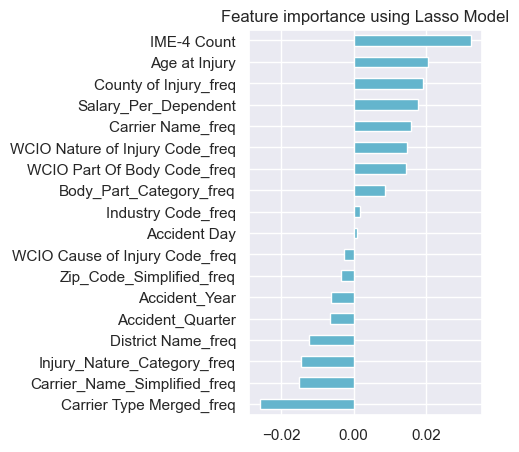

In [19]:
plot_importance(coef,'Lasso')

 ### 4.2.2. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_2"></a>

  [Back to 4.2. Numerical Features](#section_4_2)<br>
 

RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

The selected features after RFE likely overlap with those identified by LASSO, suggesting consistency in feature importance.
Using both LASSO and RFE provides a more robust feature selection by cross-validating the importance of individual features.

This block of code performs RFE to identify the best subset of features by iterating over a range of feature numbers. The code aims to maximize model performance on the validation set.

In [20]:
# RFE using Logistic Regression
model = LogisticRegression()

#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=19
)

Optimum number of features: 17
F1 Macro Score with 17 features: 0.436214



The loop evaluates models with 1 to 18 features, tracking the score for each.

The output indicates that 17 features yielded the highest validation f1_score score of 0.436214.

**Applying RFE with the Optimal Number of Features**

Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [21]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 17)

In [22]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [23]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Age at Injury                       True
IME-4 Count                         True
Accident_Quarter                    True
Accident_Year                       True
Accident Day                       False
Salary_Per_Dependent                True
Carrier_Name_Simplified_freq        True
Zip_Code_Simplified_freq            True
Industry Code_freq                  True
County of Injury_freq               True
District Name_freq                  True
WCIO Cause of Injury Code_freq      True
WCIO Nature of Injury Code_freq     True
WCIO Part Of Body Code_freq         True
Carrier Name_freq                   True
Body_Part_Category_freq             True
Injury_Nature_Category_freq         True
Carrier Type Merged_freq            True
dtype: bool

### 4.2.3. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_3"></a>
 [Back to 4.2. Numerical Features](#section_4_2)<br>



In [24]:
from utils import compare_feature_importances

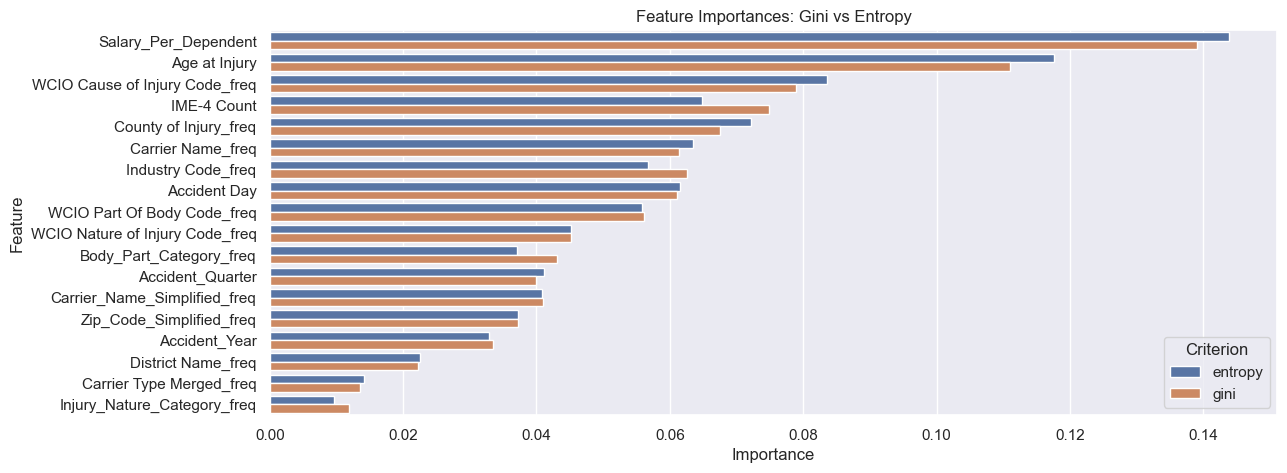

       gini   entropy               col
0  0.110961  0.117557     Age at Injury
1  0.074841  0.064892       IME-4 Count
2  0.039929  0.041171  Accident_Quarter
3  0.033516  0.032859     Accident_Year
4  0.061128  0.061522      Accident Day


In [25]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

### 4.2.4. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_4"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


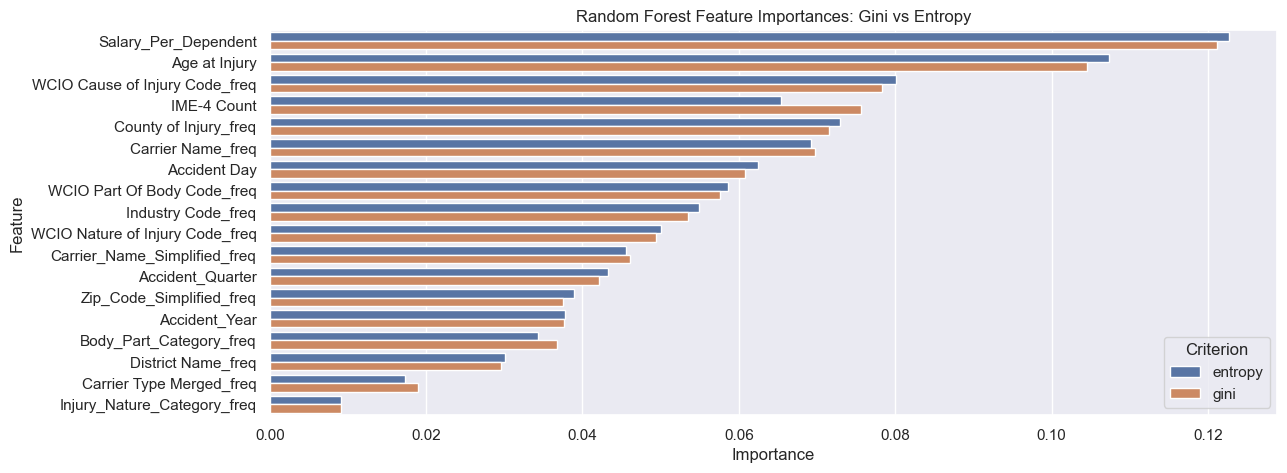

       gini   entropy               col
0  0.104570  0.107388     Age at Injury
1  0.075652  0.065392       IME-4 Count
2  0.042061  0.043319  Accident_Quarter
3  0.037648  0.037704     Accident_Year
4  0.060824  0.062436      Accident Day


In [26]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
[Back to 4. Feature Selection](#chapter4)<br>

Chi-squared and MIC for the categorical ones.

In [27]:
X_train_mic_chi2 = X_train[feature_categories['categorical'] + feature_categories['binary']]

In [28]:
X_train_mic_chi2.shape

(459219, 11)

In [29]:
X_train_mic_chi2.columns

Index(['Income_Category', 'Age Group', 'promptness_category',
       'promptness_C2_category', 'promptness_C3_category', 'Industry Risk',
       'Gender_M', 'Gender_U', 'Medical Fee Region_II',
       'Medical Fee Region_III', 'Medical Fee Region_UK'],
      dtype='object')

 ### 4.3.1. $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_3_1"></a>

[Back to 4.3. Categorical Features](#section_4_3)<br>


The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. 

In [30]:
from utils import select_high_score_features_chi2_no_model

In [31]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=6
)

Top 6 features based on Chi-square scores: ['promptness_C2_category', 'promptness_category', 'promptness_C3_category', 'Age Group', 'Income_Category', 'Gender_M']
Corresponding Chi-square scores: [3926.434088704915, 3561.501052874994, 3227.631195728296, 1354.5340717089923, 755.9224280930574, 542.3803735581471]


In [32]:
high_score_features_chi2

['promptness_C2_category',
 'promptness_category',
 'promptness_C3_category',
 'Age Group',
 'Income_Category',
 'Gender_M']

 ### 4.3.2. Mutual Information Criterion (MIC) <a class="anchor" id="sub_section_4_3_2"></a>

 [Back to 4.3. Categorical Features](#section_4_3)<br>
 

The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [33]:
from utils import select_high_score_features_MIC

In [34]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_mapped, 
    threshold=6, 
    random_state=42)

Top 6 features based on MIC scores: ['promptness_C3_category', 'Gender_M', 'Industry Risk', 'promptness_C2_category', 'Income_Category', 'promptness_category']
Corresponding MIC scores: [0.06354600947697531, 0.056096591683119756, 0.0478229509193957, 0.032932645977153285, 0.02716984611050166, 0.02595887783000439]


**Intersection of Selected Features by Chi-squared and MIC** <br>
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [35]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

['promptness_C3_category',
 'promptness_C2_category',
 'promptness_category',
 'Gender_M',
 'Income_Category']

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>
[Back to 4. Feature Selection](#chapter4)<br>

The following table evaluates all numerical features using multiple feature selection techniques: Spearman Correlation, LASSO Regression, RFE, Decision Tree, and Random Forest. Based on these combined insights, a final decision is provided in the "What to do?" column.


| **Predictor**                 | **LASSO**         | **RFE**            | **Decision Tree Importance**   | **Random Forest Importance**  | **What to do?**               |
|-------------------------------|-------------------|--------------------|--------------------------------|--------------------------------|--------------------------------|
| Carrier Type Merged_freq      |Keep              | Keep               | Low                            | Low                            | Consider include                      |
| Carrier_Name_Simplified_freq  | Discard              | Keep               | Low                            | Low                            | Discard                       |
| Injury_Nature_Category_freq   |  Discard           | Keep               | Low                            | Low                            | Discard                       |
| District Name_freq            |  Discard           | Keep               | Low                            | Low                            | Discard                       |
| Accident_Quarter              |  Discard           | Keep               | Low                            | Low                            | Discard                       |
| Accident_Year                 |Discard           | Keep               | Low                            | Low                            | Discard                       |
| Zip_Code_Simplified_freq      | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Cause of Injury Code_freq| Discard           | Keep               | Keep                           | Keep                           | Include                       |
| Accident Day                  | Discard           | Discard            | Low                           | Low                            | Discard                       |
| Industry Code_freq            |  Discard           | Keep               | Low                           | Low                            | Discard                       |
| Body_Part_Category_freq       | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Part Of Body Code_freq   | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Nature of Injury Code_freq|  Discard           | Keep               | Low                            | Low                            | Discard                       |
| Carrier Name_freq             | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Salary_Per_Dependent          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| County of Injury_freq         |  Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Age at Injury                 | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| IME-4 Count                   |  Keep              | Keep               | Keep                           | Keep                           | Include                       |

### **Categorical Feature Selection Results**

The following table summarizes the decisions for each categorical feature based on **Mutual Information (MIC)** and **Chi-Squared** (X²) results. The retained features will be used in subsequent modeling to enhance predictive performance.

| **Feature**              | **X² Results**          | **MIC Results**         | **Decision**               |
|---------------------------|-------------------------|-------------------------|----------------------------|
| promptness_C2_category | Keep                  | Keep                  | Include               |
| promptness_category    | Keep                 | -                       | Consider include in model                |
| promptness_C3_category | Keep                       | Keep                  | Include                |
| Age Group              | Keep                  | Keep                  | Include                |
| Income_Category        | Keep                  | Keep                  | Include                |
| Industry Risk         |                        | Keep                  | Consider include in model                |
| Gender_M               | Keep                  | Keep                  | Include                |
| Gender_U               | -                       | -                       | Exclude          |
| Medical Fee Region_II  | -                       | -                       | Exclude               |
| Medical Fee Region_III | -                       | -                       | Exclude               |
| Medical Fee Region_UK  | -                       | -                       | Exclude                |


In [36]:
numerical_features

['Age at Injury',
 'IME-4 Count',
 'Accident_Quarter',
 'Accident_Year',
 'Accident Day',
 'Salary_Per_Dependent',
 'Carrier_Name_Simplified_freq',
 'Zip_Code_Simplified_freq',
 'Industry Code_freq',
 'County of Injury_freq',
 'District Name_freq',
 'WCIO Cause of Injury Code_freq',
 'WCIO Nature of Injury Code_freq',
 'WCIO Part Of Body Code_freq',
 'Carrier Name_freq',
 'Body_Part_Category_freq',
 'Injury_Nature_Category_freq',
 'Carrier Type Merged_freq']

In [20]:
final_features = [
    # Categorical features selected through MIC and chi2
    'Age Group','promptness_C2_category',
    'Income_Category','Gender_M', 'promptness_C3_category',
    # Important numerical features
    'IME-4 Count', 'Age at Injury',
    'County of Injury_freq', 'Salary_Per_Dependent', 'Carrier Name_freq','WCIO Cause of Injury Code_freq']

final_features_consider = [
    # Categorical features selected through MIC and chi2
    'Age Group','promptness_C2_category','Income_Category','Gender_M', 
    'promptness_C3_category', 'Carrier Type Merged_freq', 'promptness_category','Industry Risk',
    # Important numerical features
    'IME-4 Count', 'Age at Injury',
    'County of Injury_freq', 'Salary_Per_Dependent', 'Carrier Name_freq','WCIO Cause of Injury Code_freq']


# Extracting the final features from the processed datasets
X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = df_test[final_features]

# Extracting the final features from the processed datasets
X_train_final_consider = X_train[final_features_consider]
X_val_final_consider = X_val[final_features_consider]
X_test_final_consider = df_test[final_features_consider]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")


# Print the shape of the final datasets to confirm consistency
print(f"X_train_final_consider shape: {X_train_final_consider.shape}")
print(f"X_val_final_consider shape: {X_val_final_consider.shape}")
print(f"X_test_final_consider shape: {X_test_final_consider.shape}")

X_train_final shape: (459219, 11)
X_val_final shape: (114805, 11)
X_test_final shape: (387975, 11)
X_train_final_consider shape: (459219, 14)
X_val_final_consider shape: (114805, 14)
X_test_final_consider shape: (387975, 14)


In [38]:
len(y_train_encoded)

459219

In [39]:
len(y_val_encoded)

114805

# 5. Modeling <a class="anchor" id="chapter5"></a>

[Back to ToC](#toc)<br>

## 5.1. Logistic Regression</b> <a class="anchor" id="section_5_1"></a>

[Back to 5. Modeling](#chapter5)<br>

Logistic Regression is a simple and interpretable model that is effective for binary classification when the relationship between features and the target is linear.


**Standard Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.34      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.55      0.50      0.44    459219
weighted avg       0.67      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

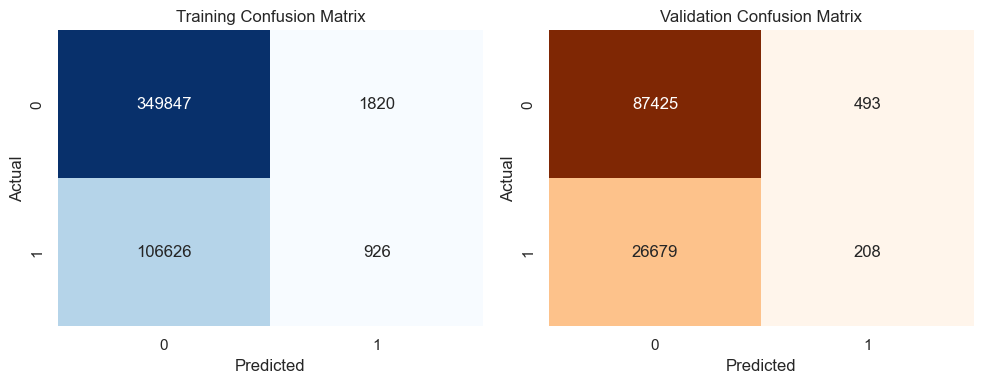

Time taken to run the cell: 3.96 seconds


In [42]:
import time

# Record the start time
start_time = time.time()

# Scale features
scaler_log = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler_log.fit_transform(X_train_final)

# Transform validation and test data using the same scaler
X_val_scaled = scaler_log.transform(X_val_final)
X_test_scaled = scaler_log.transform(X_test_final)

# Logistic Regression Model
log_reg_std = LogisticRegression(max_iter=1000, random_state=42)
log_reg_std.fit(X_train_scaled, y_train_encoded)

# Predictions on training and validation sets
pred_train_log_final_std = log_reg_std.predict(X_train_scaled)  # Corrected for training data
pred_val_log_final_std = log_reg_std.predict(X_val_scaled)      # Validation data

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_std, y_val_encoded, pred_val_log_final_std)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.39      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.58      0.50      0.44    459219
weighted avg       0.68      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

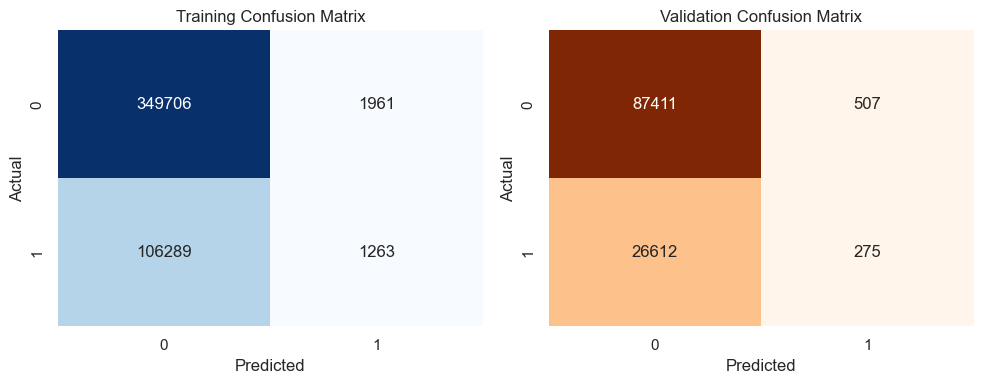

Time taken to run the cell: 3.10 seconds


In [21]:
import time

# Record the start time
start_time = time.time()

# Scale features
scaler_log = StandardScaler()

# Fit on training data and transform
X_train_scaled_consider = scaler_log.fit_transform(X_train_final_consider)

# Transform validation and test data using the same scaler
X_val_scaled_consider = scaler_log.transform(X_val_final_consider)
X_test_scaled_consider = scaler_log.transform(X_test_final_consider)

# Logistic Regression Model
log_reg_std = LogisticRegression(max_iter=1000, random_state=42)
log_reg_std.fit(X_train_scaled_consider, y_train_encoded)

# Predictions on training and validation sets
pred_train_log_final_std = log_reg_std.predict(X_train_scaled_consider)  # Corrected for training data
pred_val_log_final_std = log_reg_std.predict(X_val_scaled_consider)      # Validation data

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_std, y_val_encoded, pred_val_log_final_std)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

**Min Max Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.34      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.55      0.50      0.44    459219
weighted avg       0.67      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

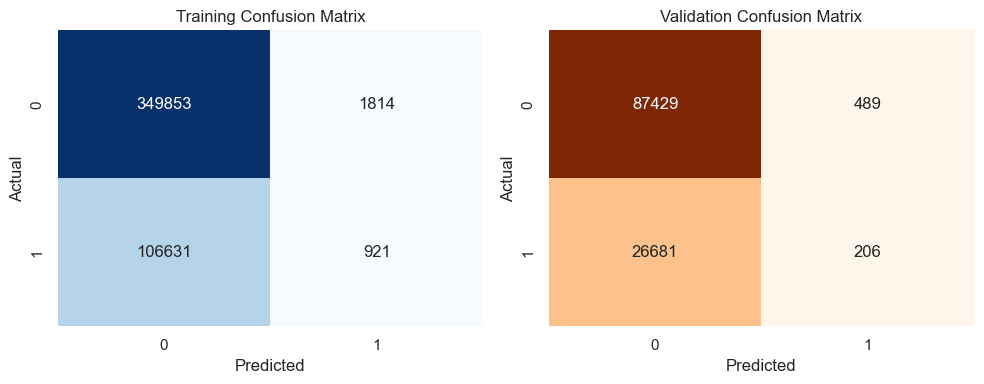

Time taken to run the cell: 4.64 seconds


In [44]:
# Record the start time
start_time = time.time()

# Scale features
scaler = MinMaxScaler()
final_features_X_train_scaled_minmax = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_minmax = scaler.transform(X_val_final)
final_features_df_test_scaled_minmax = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_minmax = LogisticRegression(max_iter=1000, random_state=42)
log_reg_minmax.fit(final_features_X_train_scaled_minmax, y_train_encoded)
pred_train_log_final_minmax = log_reg_minmax.predict(final_features_X_train_scaled_minmax)
pred_val_log_final_minmax = log_reg_minmax.predict(final_features_X_val_scaled_minmax)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_minmax, y_val_encoded, pred_val_log_final_minmax)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

**Robust Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.34      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.55      0.50      0.44    459219
weighted avg       0.67      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

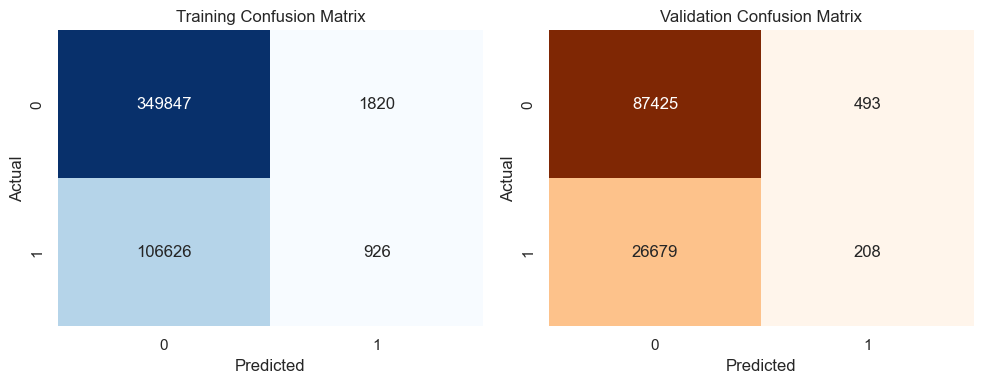

Time taken to run the cell: 3.73 seconds


In [45]:
# Record the start time
start_time = time.time() 

# Scale features
scaler = RobustScaler()
final_features_X_train_scaled_rob = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_rob = scaler.transform(X_val_final)
final_features_df_test_scaled_rob = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_rob = LogisticRegression(max_iter=1000, random_state=42)
log_reg_rob.fit(final_features_X_train_scaled_rob, y_train_encoded)
pred_train_log_final_rob = log_reg_rob.predict(final_features_X_train_scaled_rob)
pred_val_log_final_rob = log_reg_rob.predict(final_features_X_val_scaled_rob)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_rob, y_val_encoded, pred_val_log_final_rob)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

##### Train test Split
| Model Name | Scaler | Resampling Technique | F1 Score (Train)| F1 Score (Validation)| Time (seconds) |
|------------|-------------|----------------------|------------------|-----------------------|----------------------|
| Logistic Regression | Standard | None  |     0.59       |      0.61             | 1.54 s |
| Logistic Regression | MinMax | None  |         0.59         |        0.60              |  1.93 s   | 
| Logistic Regression  | Robust | None   |          0.59      |        0.60          |  2.11 s |

## 5.2. KNN</b> <a class="anchor" id="section_5_2"></a>
[Back to 5. Modeling](#chapter5)<br>



K-Nearest Neighbors Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    351667
           1       0.78      0.26      0.39    107552

    accuracy                           0.81    459219
   macro avg       0.79      0.62      0.64    459219
weighted avg       0.80      0.81      0.77    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------------------------------

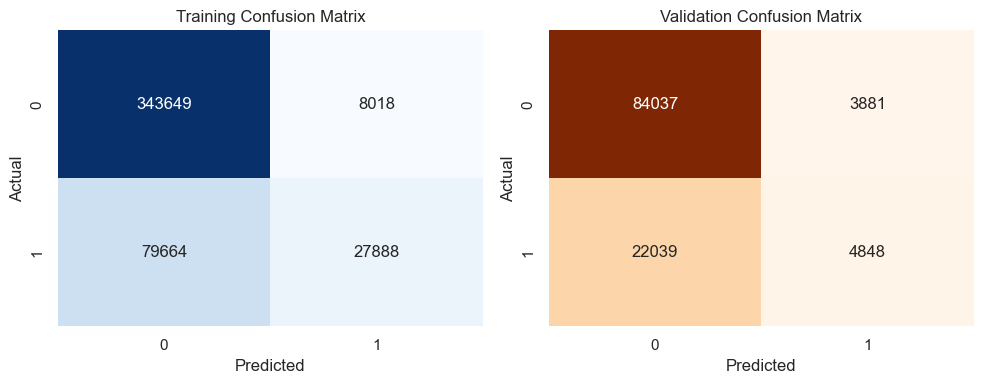

In [46]:
# Record the start time
start_time = time.time() 

# K-Nearest Neighbors Model
knn_std = KNeighborsClassifier(n_neighbors=6)
knn_std.fit(X_train_scaled, y_train_encoded)
pred_train_knn_final_std = knn_std.predict(X_train_scaled)
pred_val_knn_final_std = knn_std.predict(X_val_scaled)

# Metrics for K-Nearest Neighbors
print("\nK-Nearest Neighbors Metrics:")
metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)


K-Nearest Neighbors Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    351667
           1       0.79      0.27      0.40    107552

    accuracy                           0.81    459219
   macro avg       0.80      0.62      0.65    459219
weighted avg       0.81      0.81      0.78    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------------------------------

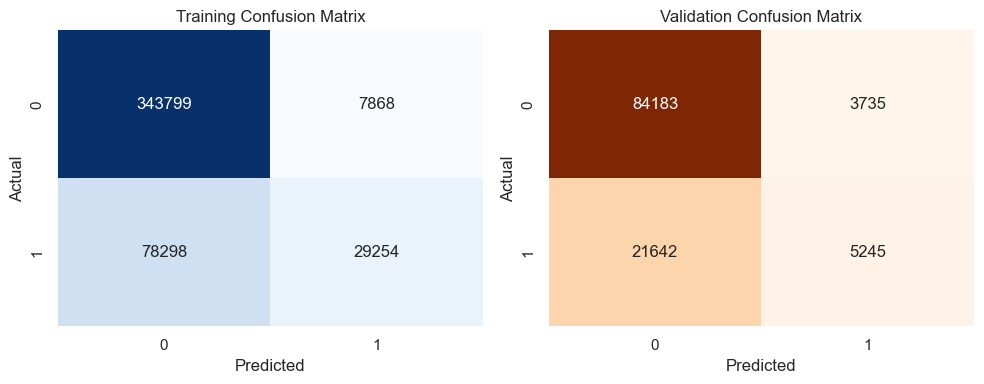

In [47]:
# Record the start time
start_time = time.time() 

# K-Nearest Neighbors Model
knn_std = KNeighborsClassifier(n_neighbors=6)
knn_std.fit(X_train_scaled_consider, y_train_encoded)
pred_train_knn_final_std = knn_std.predict(X_train_scaled_consider)
pred_val_knn_final_std = knn_std.predict(X_val_scaled_consider)

# Metrics for K-Nearest Neighbors
print("\nK-Nearest Neighbors Metrics:")
metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)

| Model Name              | Scaler | Resempling technique    | F1 Score (Train) | F1 Score (Validation) |Time (seconds) |
|--------------------------|------------------|------------------|------------------|-----------------------|-----------------------|
| KNN  | Standard | None  |       0.64        |      0.57           |        600           | 


## 5.3. Random Forest</b> <a class="anchor" id="section_5_3"></a>
[Back to 5. Modeling](#chapter5)<br>


Random Forest is an ensemble learning method that combines multiple decision trees trained on random subsets of data and features to improve accuracy and reduce overfitting. It aggregates their predictions using majority voting for classification or averaging for regression.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    351667
           1       1.00      1.00      1.00    107552

    accuracy                           1.00    459219
   macro avg       1.00      1.00      1.00    459219
weighted avg       1.00      1.00      1.00    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

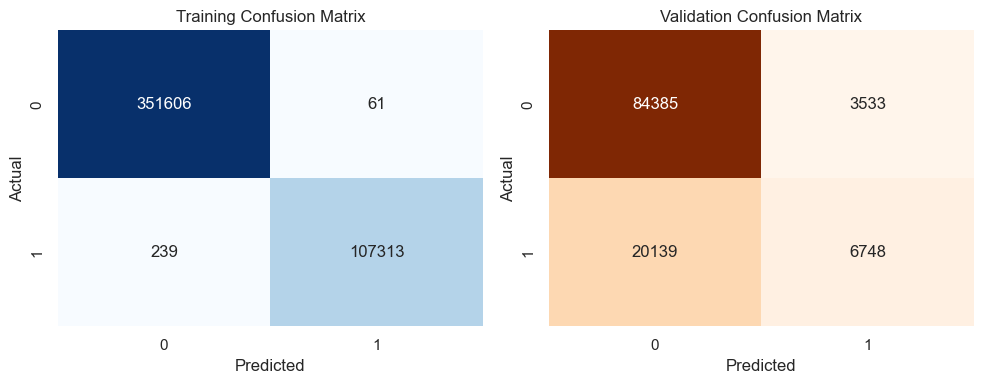

Time taken to run the cell: 163.84 seconds


In [51]:
# Record the start time
start_time = time.time()

#Initialize the model
rf_model = RandomForestClassifier(random_state=42)

#Fit the model to the train data
rf_model.fit(X_train_scaled_consider, y_train_encoded)

#Predict the model for the train data
y_pred_rf_train = rf_model.predict(X_train_scaled_consider)

#Predict the model for the validation data
y_pred_rf = rf_model.predict(X_val_scaled_consider)

#Print the classification report
metrics(y_train_encoded, y_pred_rf_train, y_val_encoded, y_pred_rf)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

Let's try to add some parameters.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    351667
           1       0.87      0.09      0.16    107552

    accuracy                           0.78    459219
   macro avg       0.83      0.54      0.52    459219
weighted avg       0.80      0.78      0.71    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

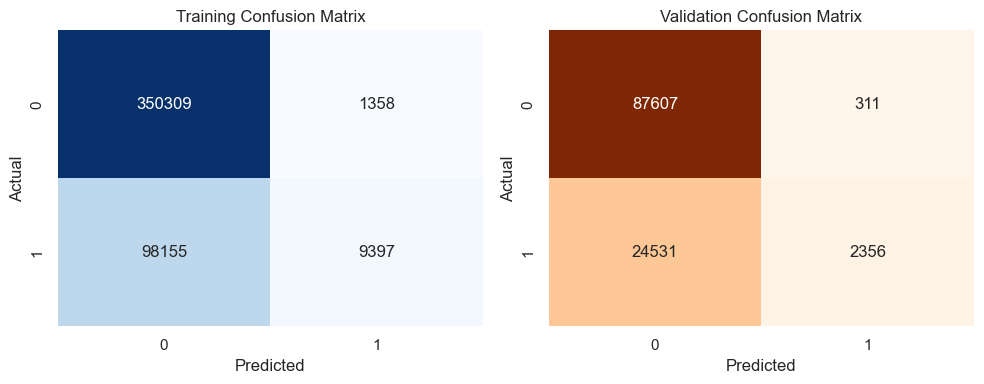

Time taken to run the cell: 43.14 seconds


In [52]:
# Record the start time
start_time = time.time()

# Random Forest Classifier
rf_std = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Fit Random Forest model with final features and calculate metrics for training and validation
rf_std.fit(X_train_scaled_consider, y_train_encoded)
pred_train_rf_std= rf_std.predict(X_train_scaled_consider)
pred_val_rf_std = rf_std.predict(X_val_scaled_consider)
metrics(y_train_encoded, pred_train_rf_std, y_val_encoded, pred_val_rf_std)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

| Model Name | Scaler  | F1 Score (Train)| F1 Score (Validation)| Times |
|------------|-------------|----------------------|------------------|-----------------------|
| Random Forest  | Standard  |     0.58        |        0.58    |211.23 s |
| Random Forest  | Standard |      0.52      |     0.52        | 98.14 s|


---

## 5.4. Decision Trees </b> <a class="anchor" id="section_5_4"></a>
[Back to 5. Modeling](#chapter5)<br>

Decision Trees are versatile models that can capture non-linear patterns by splitting data based on feature values.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    351667
           1       1.00      1.00      1.00    107552

    accuracy                           1.00    459219
   macro avg       1.00      1.00      1.00    459219
weighted avg       1.00      1.00      1.00    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

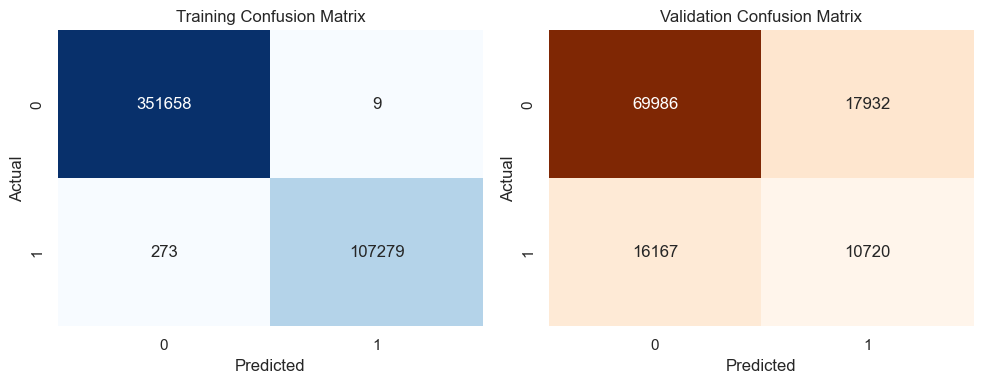

Time taken to run the cell: 8.14 seconds


In [48]:
# Record the start time
start_time = time.time()

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the train data
dt_model.fit(X_train_scaled_consider, y_train_encoded)

# Predict the model for the train data
y_pred_dt_train = dt_model.predict(X_train_scaled_consider)

# Predict the model for the validation data
y_pred_dt = dt_model.predict(X_val_scaled_consider)

#Print the metric report
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

Despite increasing the F1-Score in the validation set, we have overfitting. So fit Decision Tree model with pruning parameters for final features and potential value features migth help with this.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.98      0.87    351667
           1       0.67      0.13      0.22    107552

    accuracy                           0.78    459219
   macro avg       0.73      0.56      0.55    459219
weighted avg       0.76      0.78      0.72    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

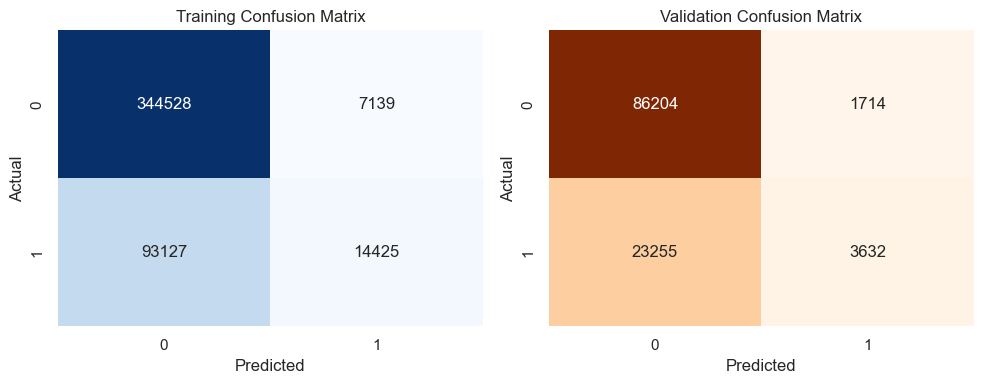

Time taken to run the cell: 9.08 seconds


In [ ]:
# Record the start time
start_time = time.time() 

# Pruned Decision Tree Classifier
pruned_dt_std = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split =150)

# Fit pruned Decision Tree model with final features and calculate metrics for training and validation
pruned_dt_std.fit(X_train_scaled_consider, y_train_encoded)
pred_train_pruned_dt_std = pruned_dt_std.predict(X_train_scaled_consider)
pred_val_pruned_dt_std = pruned_dt_std.predict(X_val_scaled_consider)
metrics(y_train_encoded, pred_train_pruned_dt_std, y_val_encoded, pred_val_pruned_dt_std)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.71      0.77    351667
           1       0.38      0.58      0.46    107552

    accuracy                           0.68    459219
   macro avg       0.61      0.65      0.62    459219
weighted avg       0.74      0.68      0.70    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

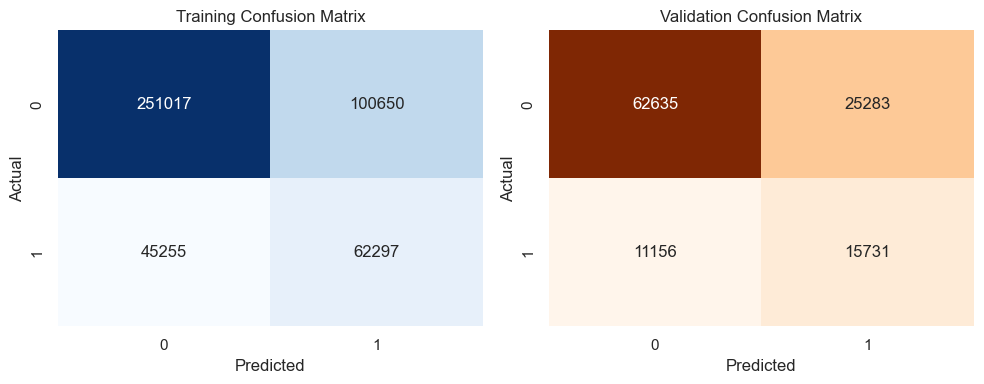

Time taken to run the cell: 525.52 seconds


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Record the start time
start_time = time.time()

# Apply Borderline-SMOTE to handle class imbalance
smote = BorderlineSMOTE(random_state=42, kind='borderline-1')  # You can also try 'borderline-2'
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_consider, y_train_encoded)

# Pruned Decision Tree Classifier
pruned_dt_smote = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=150, min_samples_leaf=150)

# Fit the pruned Decision Tree model with SMOTE data
pruned_dt_smote.fit(X_train_smote, y_train_smote)

# Make predictions on training and validation sets
pred_train_smote = pruned_dt_smote.predict(X_train_scaled_consider)
pred_val_smote = pruned_dt_smote.predict(X_val_scaled_consider)

# Calculate metrics for training and validation
metrics(y_train_encoded, pred_train_smote, y_val_encoded, pred_val_smote)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


**Grid Search**

Grid Search is a systematic method for hyperparameter tuning in machine learning models. It tests all possible combinations of specified hyperparameters to find the configuration that yields the best performance on a given validation metric. The process involves:

Defining a parameter grid with potential values for each hyperparameter.
Evaluating the model's performance using cross-validation for every parameter combination.
Selecting the best combination based on a scoring metric (e.g., accuracy, F1-score).
While Grid Search can be computationally expensive, it ensures that the best hyperparameter combination is selected systematically.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train_scaled_consider, y_train_encoded)
best_model = grid_search.best_estimator_

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    351667
           1       0.71      0.21      0.32    107552

    accuracy                           0.79    459219
   macro avg       0.76      0.59      0.60    459219
weighted avg       0.78      0.79      0.75    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

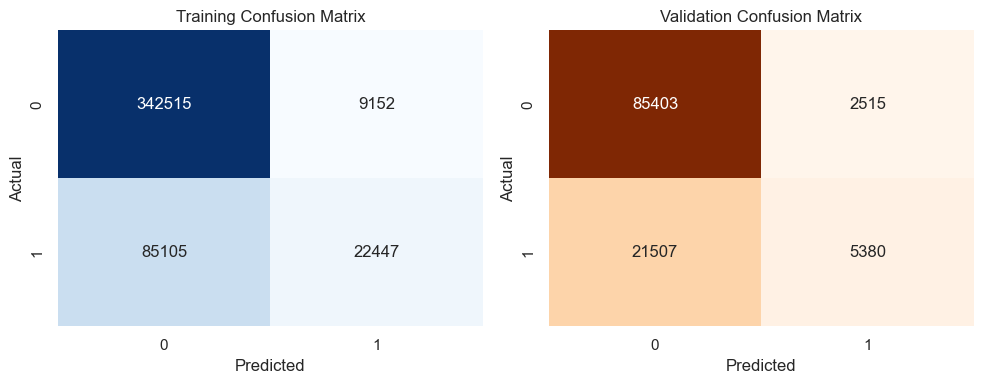

Time taken to run the cell: 4.55 seconds


In [23]:
# Record the start time
start_time = time.time()

# Train the best model obtained from GridSearchCV
best_model.fit(X_train_scaled_consider, y_train_encoded)

# Predict on train data
y_pred_dt_train = best_model.predict(X_train_scaled_consider)

# Predict on validation data
y_pred_dt = best_model.predict(X_val_scaled_consider)

# Evaluate using metrics()
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

## 5.5. Gradient Boosting </b> <a class="anchor" id="section_5_5"></a>
[Back to 5. Modeling ](#chapter5)<br>


Gradient Boosting models (e.g., XGBoost, LightGBM) are powerful ensemble methods that iteratively improve performance by minimizing errors. <br>

#### **XGBClassifier**

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.97      0.88    351667
           1       0.71      0.26      0.38    107552

    accuracy                           0.80    459219
   macro avg       0.76      0.61      0.63    459219
weighted avg       0.79      0.80      0.76    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

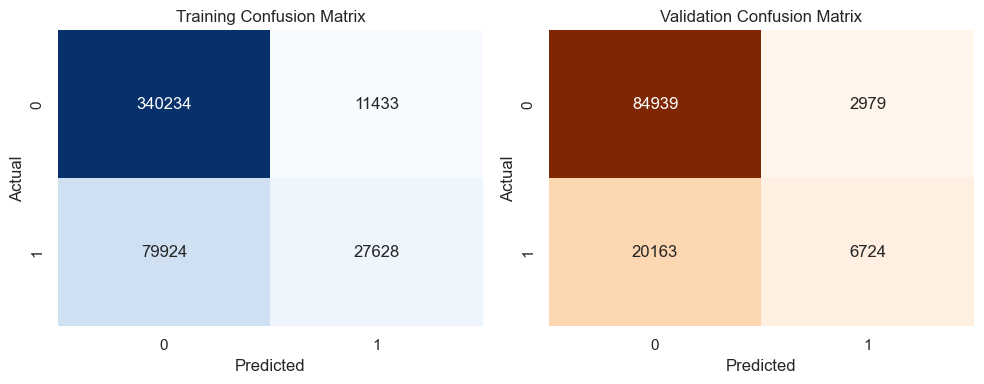

Time taken to run the cell: 9.83 seconds


In [56]:
# Record the start time
start_time = time.time()

# XGBoost Classifier
xgb_std = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit XGBoost model with final features and calculate metrics for training and validation
xgb_std.fit(X_train_scaled_consider, y_train_encoded)
pred_train_xgb_std = xgb_std.predict(X_train_scaled_consider)
pred_val_xgb_std = xgb_std.predict(X_val_scaled_consider)

metrics(y_train_encoded, pred_train_xgb_std, y_val_encoded, pred_val_xgb_std)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

#### **CatBoost (CatBoostClassifier)** <br>
CatBoost is a gradient boosting framework designed to natively support categorical features. It is efficient, easy to implement, and often performs well on tabular data.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.97      0.89    351667
           1       0.74      0.28      0.40    107552

    accuracy                           0.81    459219
   macro avg       0.78      0.62      0.64    459219
weighted avg       0.80      0.81      0.77    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

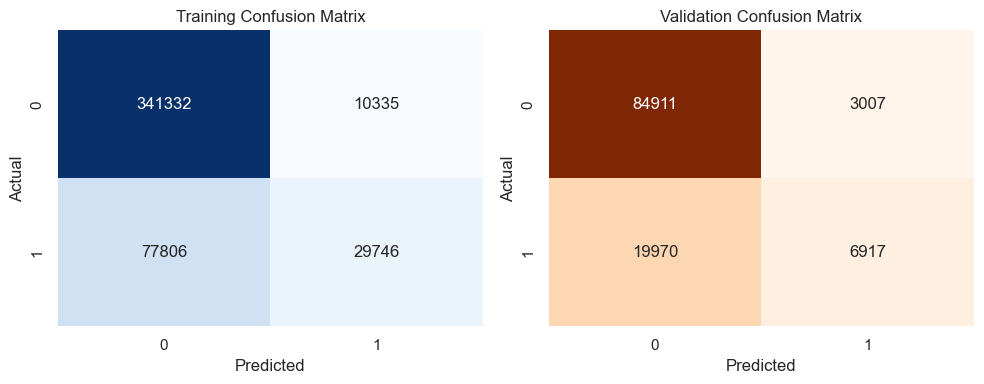

Time taken to run the cell: 245.46 seconds


In [57]:
# Record the start time
start_time = time.time()

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)  # Set verbose=0 to suppress training logs

# Fit the model to the training data
catboost_model.fit(X_train_scaled_consider, y_train_encoded)

# Predict the model for the training data
y_pred_catboost_train = catboost_model.predict(X_train_scaled_consider)

# Predict the model for the validation data
y_pred_catboost = catboost_model.predict(X_val_scaled_consider)

# Print the classification report
metrics(y_train_encoded, y_pred_catboost_train, y_val_encoded, y_pred_catboost)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

#### **LightGBM**

LightGBM is a gradient boosting framework designed for fast training and low memory usage. It works well with large datasets and can efficiently handle imbalanced data

[LightGBM] [Info] Number of positive: 107552, number of negative: 351667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 459219, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.73      0.79    351667
       

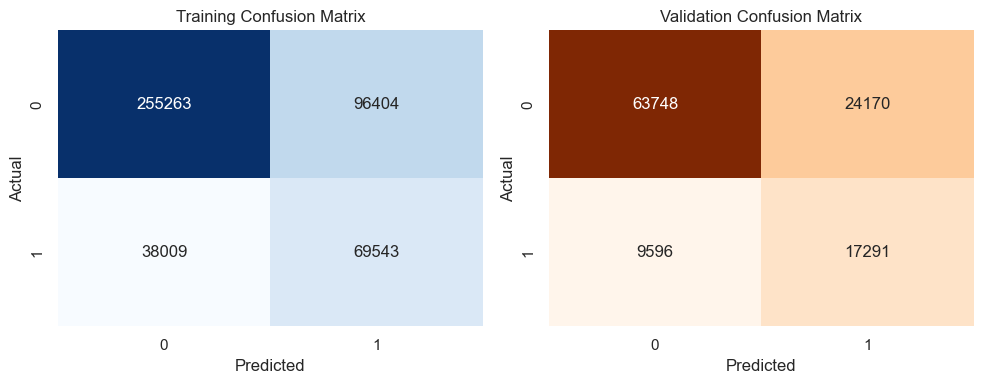

Time taken to run the cell: 3.79 seconds


In [51]:
# Initialize the LightGBM model
from lightgbm import LGBMClassifier
import time

# Record the start time
start_time = time.time()

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
lgbm_model.fit(X_train_scaled_consider, y_train_encoded)

# Predict on the training and validation data
y_pred_lgbm_train = lgbm_model.predict(X_train_scaled_consider)
y_pred_lgbm_val = lgbm_model.predict(X_val_scaled_consider)

# Evaluate the model
metrics(y_train_encoded, y_pred_lgbm_train, y_val_encoded, y_pred_lgbm_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


Since the LightGBM model has the best performance we will built a grid search to find the best hyperparameters, to see if its possible to increase the f1_macro.

In [45]:
# Define the XGBoost model
lgbm_model = LGBMClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, 
                           scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled_consider, y_train_encoded)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the best F1 Macro score
print(f"Best parameters found: {best_params}")
print(f"Best F1 Macro score from GridSearchCV: {best_score:.4f}")

# Retrain the best model on the full training set
best_lgbm_model = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Number of positive: 107552, number of negative: 351667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 459219, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234206 -> initscore=-1.184710
[LightGBM] [Info] Start training from score -1.184710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.97      0.88    351667
           1       0.73      0.27      0.40    107552

    accuracy                           0.81    459219
   macro avg       0.77      0.62      0.64    459219
weighted avg       0.79      0.81      0.77    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

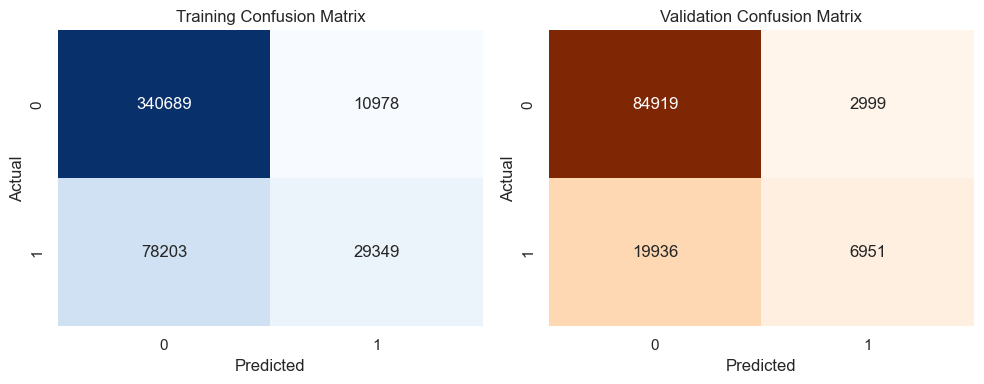

In [46]:
#Make predictions on the training set
train_preds = best_lgbm_model.predict(X_train_scaled_consider)

# Make predictions on the validation set
val_preds = best_lgbm_model.predict(X_val_scaled_consider)

# Calculate metrics for training and validation sets
metrics(y_train_encoded, train_preds, y_val_encoded, val_preds)

## 5.6. Voting Classifier </b> <a class="anchor" id="section_5_6"></a>
 [Back to 5. Modeling ](#chapter5)<br>

 A Voting Classifier is an ensemble learning method that combines predictions from multiple different models to make a final decision

In [51]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# Initialize the models
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt = best_model  # Assume best_model is defined elsewhere
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
catboost = CatBoostClassifier(learning_rate=0.05, depth=6, iterations=1000, random_state=42, verbose=0)
nb = GaussianNB()  # Add Naive Bayes

# Create a VotingClassifier (ensemble)
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm),
        ('dt', dt),
        ('lr', lr),
        ('catboost', catboost),
        ('nb', nb)  # Add Naive Bayes to the ensemble
    ],
    voting='soft'
)

# Train the individual models
rf.fit(X_train_scaled_consider, y_train_encoded)
lgbm.fit(X_train_scaled_consider, y_train_encoded)
dt.fit(X_train_scaled_consider, y_train_encoded)
lr.fit(X_train_scaled_consider, y_train_encoded)
catboost.fit(X_train_scaled_consider, y_train_encoded)
nb.fit(X_train_scaled_consider, y_train_encoded)  # Train Naive Bayes

# Train the ensemble model
ensemble.fit(X_train_scaled_consider, y_train_encoded)

# Make predictions on the validation set
rf_train_preds = rf.predict(X_train_scaled_consider)
rf_val_preds = rf.predict(X_val_scaled_consider)

lgbm_train_preds = lgbm.predict(X_train_scaled_consider)
lgbm_val_preds = lgbm.predict(X_val_scaled_consider)

dt_train_preds = dt.predict(X_train_scaled_consider)
dt_val_preds = dt.predict(X_val_scaled_consider)

lr_train_preds = lr.predict(X_train_scaled_consider)
lr_val_preds = lr.predict(X_val_scaled_consider)

catboost_train_preds = catboost.predict(X_train_scaled_consider)
catboost_val_preds = catboost.predict(X_val_scaled_consider)

nb_train_preds = nb.predict(X_train_scaled_consider)
nb_val_preds = nb.predict(X_val_scaled_consider)

ensemble_train_preds = ensemble.predict(X_train_scaled_consider)
ensemble_val_preds = ensemble.predict(X_val_scaled_consider)

# Calculate F1 Macro score
rf_f1_train = f1_score(y_train_encoded, rf_train_preds, average='macro')
rf_f1_val = f1_score(y_val_encoded, rf_val_preds, average='macro')

lgbm_f1_train = f1_score(y_train_encoded, lgbm_train_preds, average='macro')
lgbm_f1_val = f1_score(y_val_encoded, lgbm_val_preds, average='macro')

dt_f1_train = f1_score(y_train_encoded, dt_train_preds, average='macro')
dt_f1_val = f1_score(y_val_encoded, dt_val_preds, average='macro')

lr_f1_train = f1_score(y_train_encoded, lr_train_preds, average='macro')
lr_f1_val = f1_score(y_val_encoded, lr_val_preds, average='macro')

catboost_f1_train = f1_score(y_train_encoded, catboost_train_preds, average='macro')
catboost_f1_val = f1_score(y_val_encoded, catboost_val_preds, average='macro')

nb_f1_train = f1_score(y_train_encoded, nb_train_preds, average='macro')
nb_f1_val = f1_score(y_val_encoded, nb_val_preds, average='macro')

ensemble_f1_train = f1_score(y_train_encoded, ensemble_train_preds, average='macro')
ensemble_f1_val = f1_score(y_val_encoded, ensemble_val_preds, average='macro')

# Print the F1 Macro scores
print(f"Random Forest F1 Macro - Train: {rf_f1_train:.4f}, Validation: {rf_f1_val:.4f}")
print(f"LightGBM F1 Macro - Train: {lgbm_f1_train:.4f}, Validation: {lgbm_f1_val:.4f}")
print(f"Decision Tree F1 Macro - Train: {dt_f1_train:.4f}, Validation: {dt_f1_val:.4f}")
print(f"Logistic Regression F1 Macro - Train: {lr_f1_train:.4f}, Validation: {lr_f1_val:.4f}")
print(f"CatBoost F1 Macro - Train: {catboost_f1_train:.4f}, Validation: {catboost_f1_val:.4f}")
print(f"Naive Bayes F1 Macro - Train: {nb_f1_train:.4f}, Validation: {nb_f1_val:.4f}")
print(f"Ensemble F1 Macro - Train: {ensemble_f1_train:.4f}, Validation: {ensemble_f1_val:.4f}")

[LightGBM] [Info] Number of positive: 107552, number of negative: 351667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 459219, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 107552, number of negative: 351667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 459219, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.00000

We can also plot each bar to visualize the differences in performance.

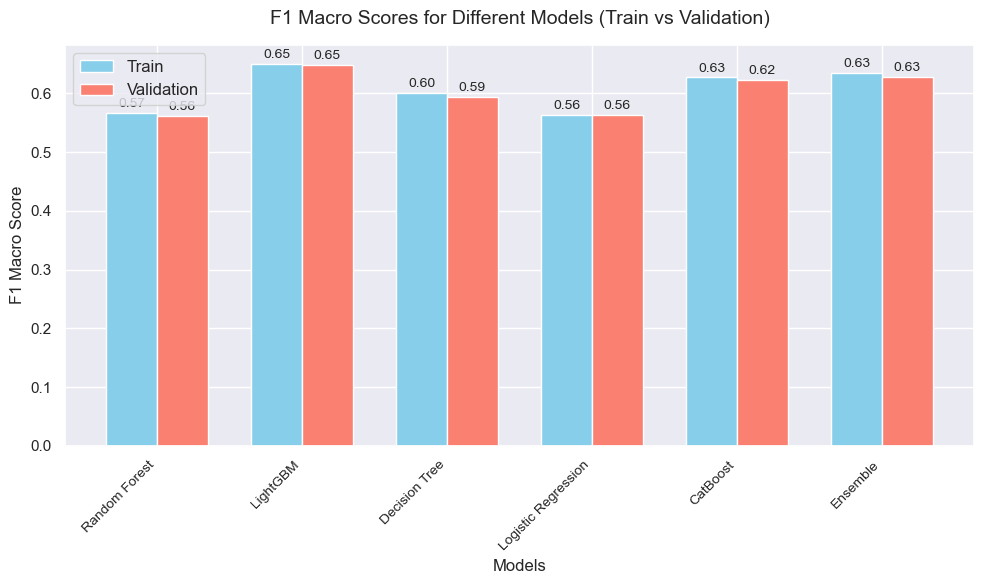

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the models' F1 scores for train and validation sets
models = ['Random Forest', 'LightGBM', 'Decision Tree', 'Logistic Regression', 'CatBoost', 'Ensemble']
train_f1_scores = [rf_f1_train, lgbm_f1_train, dt_f1_train, lr_f1_train, catboost_f1_train, ensemble_f1_train]
val_f1_scores = [rf_f1_val, lgbm_f1_val, dt_f1_val, lr_f1_val, catboost_f1_val, ensemble_f1_val]

# Define bar positions
x = np.arange(len(models))  # Number of models
bar_width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))

# Plot train F1 scores
bars_train = plt.bar(x - bar_width / 2, train_f1_scores, width=bar_width, label='Train', color='skyblue')

# Plot validation F1 scores
bars_val = plt.bar(x + bar_width / 2, val_f1_scores, width=bar_width, label='Validation', color='salmon')

# Adding labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Macro Score', fontsize=12)
plt.title('F1 Macro Scores for Different Models (Train vs Validation)', fontsize=14, pad=15)
plt.xticks(x, models, rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)

# Add F1 scores above each bar
for bar in bars_train:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars_val:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Improve layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

Let's try with SMOTE techniques.

In [53]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

# Apply Borderline-SMOTE to handle class imbalance
smote = BorderlineSMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled_consider, y_train_encoded)

# Initialize the models
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt = best_model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')  # Logistic Regression
catboost = CatBoostClassifier(learning_rate=0.05, depth=6, iterations=1000, random_state=42, verbose=0)  # CatBoost

# Create a VotingClassifier (ensemble)
ensemble = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('dt', dt), ('lr', lr), ('catboost', catboost)], voting='soft')

# Train the individual models on the resampled dataset
rf.fit(X_train_res, y_train_res)
lgbm.fit(X_train_res, y_train_res)
dt.fit(X_train_res, y_train_res)
lr.fit(X_train_res, y_train_res)
catboost.fit(X_train_res, y_train_res)  # Train CatBoost

# Train the ensemble model on the resampled dataset
ensemble.fit(X_train_res, y_train_res)

# Make predictions on the validation set
rf_train_preds = rf.predict(X_train_res)
rf_val_preds = rf.predict(X_val_scaled_consider)

lgbm_train_preds = lgbm.predict(X_train_res)
lgbm_val_preds = lgbm.predict(X_val_scaled_consider)

dt_train_preds = dt.predict(X_train_res)
dt_val_preds = dt.predict(X_val_scaled_consider)

lr_train_preds = lr.predict(X_train_res)
lr_val_preds = lr.predict(X_val_scaled_consider)

catboost_train_preds = catboost.predict(X_train_res)
catboost_val_preds = catboost.predict(X_val_scaled_consider)

ensemble_train_preds = ensemble.predict(X_train_res)
ensemble_val_preds = ensemble.predict(X_val_scaled_consider)

# Calculate F1 Macro score
rf_f1_train = f1_score(y_train_res, rf_train_preds, average='macro')
rf_f1_val = f1_score(y_val_encoded, rf_val_preds, average='macro')

lgbm_f1_train = f1_score(y_train_res, lgbm_train_preds, average='macro')
lgbm_f1_val = f1_score(y_val_encoded, lgbm_val_preds, average='macro')

dt_f1_train = f1_score(y_train_res, dt_train_preds, average='macro')
dt_f1_val = f1_score(y_val_encoded, dt_val_preds, average='macro')

lr_f1_train = f1_score(y_train_res, lr_train_preds, average='macro')
lr_f1_val = f1_score(y_val_encoded, lr_val_preds, average='macro')

catboost_f1_train = f1_score(y_train_res, catboost_train_preds, average='macro')
catboost_f1_val = f1_score(y_val_encoded, catboost_val_preds, average='macro')

ensemble_f1_train = f1_score(y_train_res, ensemble_train_preds, average='macro')
ensemble_f1_val = f1_score(y_val_encoded, ensemble_val_preds, average='macro')

# Print the F1 Macro scores
print(f"Random Forest F1 Macro - Train: {rf_f1_train:.4f}, Validation: {rf_f1_val:.4f}")
print(f"LightGBM F1 Macro - Train: {lgbm_f1_train:.4f}, Validation: {lgbm_f1_val:.4f}")
print(f"Decision Tree F1 Macro - Train: {dt_f1_train:.4f}, Validation: {dt_f1_val:.4f}")
print(f"Logistic Regression F1 Macro - Train: {lr_f1_train:.4f}, Validation: {lr_f1_val:.4f}")
print(f"CatBoost F1 Macro - Train: {catboost_f1_train:.4f}, Validation: {catboost_f1_val:.4f}")
print(f"Ensemble F1 Macro - Train: {ensemble_f1_train:.4f}, Validation: {ensemble_f1_val:.4f}")

[LightGBM] [Info] Number of positive: 351667, number of negative: 351667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 703334, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 351667, number of negative: 351667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 703334, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Random Forest F1 Macro - Train: 0.7217, Validation: 

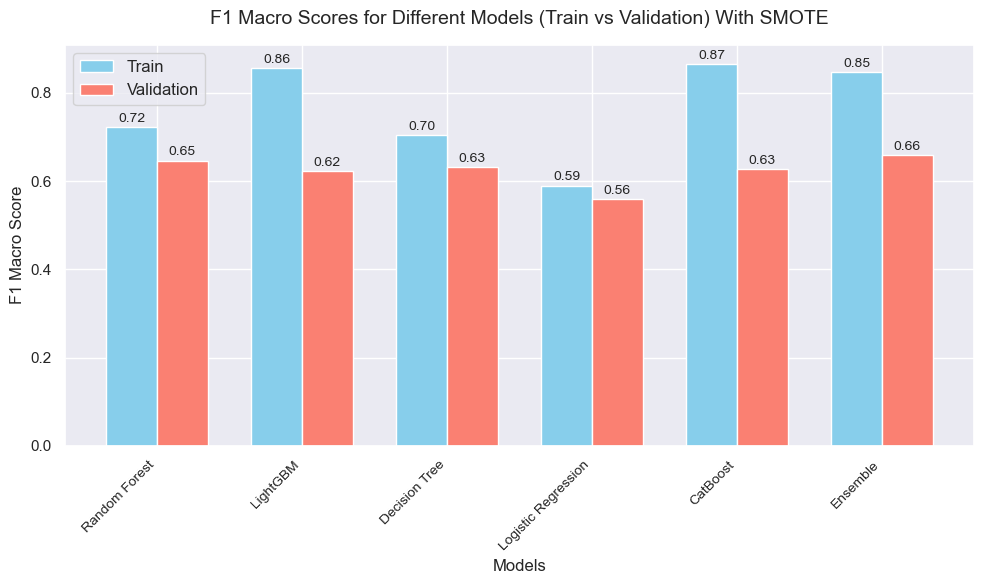

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the models' F1 scores for train and validation sets
models = ['Random Forest', 'LightGBM', 'Decision Tree', 'Logistic Regression', 'CatBoost', 'Ensemble']
train_f1_scores = [rf_f1_train, lgbm_f1_train, dt_f1_train, lr_f1_train, catboost_f1_train, ensemble_f1_train]
val_f1_scores = [rf_f1_val, lgbm_f1_val, dt_f1_val, lr_f1_val, catboost_f1_val, ensemble_f1_val]

# Define bar positions
x = np.arange(len(models))  # Number of models
bar_width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))

# Plot train F1 scores
bars_train = plt.bar(x - bar_width / 2, train_f1_scores, width=bar_width, label='Train', color='skyblue')

# Plot validation F1 scores
bars_val = plt.bar(x + bar_width / 2, val_f1_scores, width=bar_width, label='Validation', color='salmon')

# Adding labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Macro Score', fontsize=12)
plt.title('F1 Macro Scores for Different Models (Train vs Validation) With SMOTE', fontsize=14, pad=15)
plt.xticks(x, models, rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)

# Add F1 scores above each bar
for bar in bars_train:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars_val:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Improve layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

As we can see it improves the f1_score but it also adds overfitting that we didnt had. For that now the focus is on tuning hyperparameters, introducing regularization, and reducing the effect of oversampling.

In [29]:
# Apply Borderline-SMOTE with reduced oversampling
smote = BorderlineSMOTE(sampling_strategy=0.6, random_state=42)  # Reduced sampling_strategy
X_train_res, y_train_res = smote.fit_resample(X_train_scaled_consider, y_train_encoded)

# Initialize models with added regularization
rf = RandomForestClassifier(
    n_estimators=100, max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42
)
dt = best_model  # Assuming `best_model` is already optimized
lgbm = LGBMClassifier(
    n_estimators=200, learning_rate=0.03, max_depth=6, reg_alpha=1.5, reg_lambda=1.5, random_state=42
)
lr = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, random_state=42)
catboost = CatBoostClassifier(
    learning_rate=0.03, depth=6, iterations=500, random_state=42, verbose=0, l2_leaf_reg=3
)

# Ensemble with soft voting
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('lgbm', lgbm), ('dt', dt), ('lr', lr), ('catboost', catboost)], voting='soft'
)

# Create a VotingClassifier (ensemble)
ensemble = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('dt', dt), ('lr', lr), ('catboost', catboost)], voting='soft')

# Train individual models with added regularization
rf.fit(X_train_res, y_train_res)
lgbm.fit(X_train_res, y_train_res, eval_set=[(X_val_scaled_consider, y_val_encoded)])
dt.fit(X_train_res, y_train_res)
lr.fit(X_train_res, y_train_res)
catboost.fit(X_train_res, y_train_res, eval_set=[(X_val_scaled_consider, y_val_encoded)], early_stopping_rounds=50)

# Train the ensemble model on the resampled dataset
ensemble.fit(X_train_res, y_train_res)

# Make predictions on the validation set
rf_train_preds = rf.predict(X_train_res)
rf_val_preds = rf.predict(X_val_scaled_consider)

lgbm_train_preds = lgbm.predict(X_train_res)
lgbm_val_preds = lgbm.predict(X_val_scaled_consider)

dt_train_preds = dt.predict(X_train_res)
dt_val_preds = dt.predict(X_val_scaled_consider)

lr_train_preds = lr.predict(X_train_res)
lr_val_preds = lr.predict(X_val_scaled_consider)

catboost_train_preds = catboost.predict(X_train_res)
catboost_val_preds = catboost.predict(X_val_scaled_consider)

ensemble_train_preds = ensemble.predict(X_train_res)
ensemble_val_preds = ensemble.predict(X_val_scaled_consider)

# Calculate F1 Macro score
rf_f1_train = f1_score(y_train_res, rf_train_preds, average='macro')
rf_f1_val = f1_score(y_val_encoded, rf_val_preds, average='macro')

lgbm_f1_train = f1_score(y_train_res, lgbm_train_preds, average='macro')
lgbm_f1_val = f1_score(y_val_encoded, lgbm_val_preds, average='macro')

dt_f1_train = f1_score(y_train_res, dt_train_preds, average='macro')
dt_f1_val = f1_score(y_val_encoded, dt_val_preds, average='macro')

lr_f1_train = f1_score(y_train_res, lr_train_preds, average='macro')
lr_f1_val = f1_score(y_val_encoded, lr_val_preds, average='macro')

catboost_f1_train = f1_score(y_train_res, catboost_train_preds, average='macro')
catboost_f1_val = f1_score(y_val_encoded, catboost_val_preds, average='macro')

ensemble_f1_train = f1_score(y_train_res, ensemble_train_preds, average='macro')
ensemble_f1_val = f1_score(y_val_encoded, ensemble_val_preds, average='macro')

# Print the F1 Macro scores
print(f"Random Forest F1 Macro - Train: {rf_f1_train:.4f}, Validation: {rf_f1_val:.4f}")
print(f"LightGBM F1 Macro - Train: {lgbm_f1_train:.4f}, Validation: {lgbm_f1_val:.4f}")
print(f"Decision Tree F1 Macro - Train: {dt_f1_train:.4f}, Validation: {dt_f1_val:.4f}")
print(f"Logistic Regression F1 Macro - Train: {lr_f1_train:.4f}, Validation: {lr_f1_val:.4f}")
print(f"CatBoost F1 Macro - Train: {catboost_f1_train:.4f}, Validation: {catboost_f1_val:.4f}")
print(f"Ensemble F1 Macro - Train: {ensemble_f1_train:.4f}, Validation: {ensemble_f1_val:.4f}")

[LightGBM] [Info] Number of positive: 211000, number of negative: 351667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Number of data points in the train set: 562667, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375000 -> initscore=-0.510827
[LightGBM] [Info] Start training from score -0.510827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 211000, number of negative: 351667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Nu

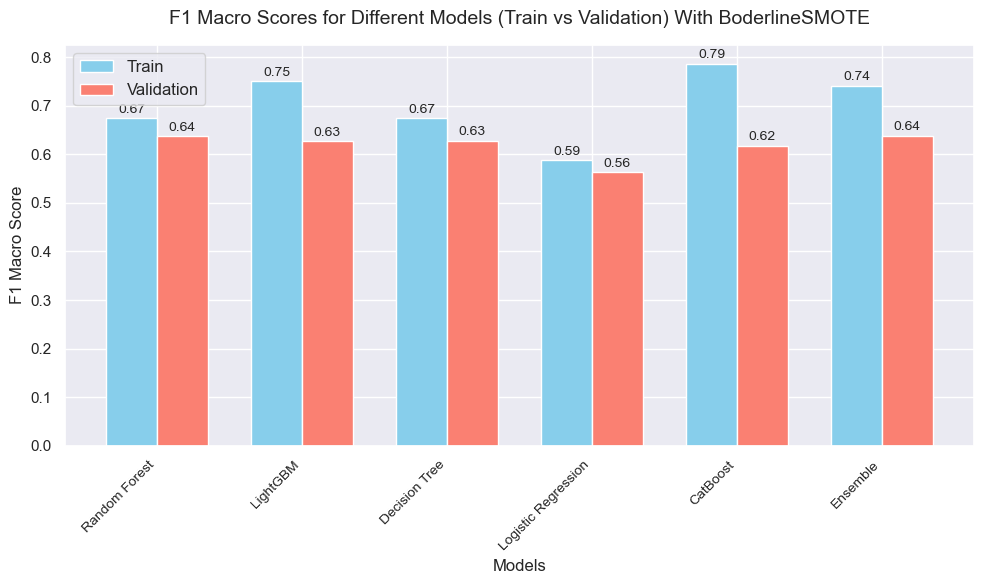

In [30]:
# Initialize the models' F1 scores for train and validation sets
models = ['Random Forest', 'LightGBM', 'Decision Tree', 'Logistic Regression', 'CatBoost', 'Ensemble']
train_f1_scores = [rf_f1_train, lgbm_f1_train, dt_f1_train, lr_f1_train, catboost_f1_train, ensemble_f1_train]
val_f1_scores = [rf_f1_val, lgbm_f1_val, dt_f1_val, lr_f1_val, catboost_f1_val, ensemble_f1_val]

# Define bar positions
x = np.arange(len(models))  # Number of models
bar_width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))

# Plot train F1 scores
bars_train = plt.bar(x - bar_width / 2, train_f1_scores, width=bar_width, label='Train', color='skyblue')

# Plot validation F1 scores
bars_val = plt.bar(x + bar_width / 2, val_f1_scores, width=bar_width, label='Validation', color='salmon')

# Adding labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Macro Score', fontsize=12)
plt.title('F1 Macro Scores for Different Models (Train vs Validation) With BoderlineSMOTE', fontsize=14, pad=15)
plt.xticks(x, models, rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)

# Add F1 scores above each bar
for bar in bars_train:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars_val:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Improve layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

## 5.7. Ensemble Method Using Weighted Probabilities  </b> <a class="anchor" id="section_5_7"></a>
 [Back to 5. Modeling ](#chapter5)<br>

 In this section, we implement an ensemble method where predictions are made by combining the class probabilities of individual models (Random Forest, XGBoost, and Logistic Regression). Each model's contribution is weighted based on its relative importance, and the final ensemble probabilities are computed as a weighted average.

We adjust the classification threshold to optimize recall for the positive class (class 1) and evaluate the ensemble's performance using precision, recall, and F1-score. Additionally, we compare the ensemble's results with those of the individual models through a detailed performance table and a bar chart for visualization.

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score

smote = BorderlineSMOTE(n_jobs=-1, random_state=42) 
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled_consider, y_train_encoded)


# Train individual models
print("Training Random Forest...")
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
random_forest.fit(X_train_balanced, y_train_balanced)

print("Training LightGBM...")
lightgbm = LGBMClassifier(random_state=42)
lightgbm.fit(X_train_balanced, y_train_balanced)

print("Training Decision Tree...")
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
decision_tree.fit(X_train_balanced, y_train_balanced)

print("Training CatBoost...")
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost.fit(X_train_balanced, y_train_balanced)

print("Training Gaussian Naive Bayes...")
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_balanced, y_train_balanced)

# Get probabilities for ensemble
rf_probs = random_forest.predict_proba(X_val_scaled_consider)[:, 1]
lgbm_probs = lightgbm.predict_proba(X_val_scaled_consider)[:, 1]
dt_probs = decision_tree.predict_proba(X_val_scaled_consider)[:, 1]
catboost_probs = catboost.predict_proba(X_val_scaled_consider)[:, 1]
gnb_probs = gaussian_nb.predict_proba(X_val_scaled_consider)[:, 1]

# Create ensemble with weights
weights = [0.4, 0.2, 0.1, 0.2, 0.1]  # Adjusted weights for ensemble
ensemble_probs = (
    weights[0] * rf_probs +
    weights[1] * lgbm_probs +
    weights[2] * dt_probs +
    weights[3] * catboost_probs +
    weights[4] * gnb_probs
)

# Adjust threshold
threshold = 0.3
ensemble_preds = (ensemble_probs > threshold).astype(int)

Training Random Forest...
Training LightGBM...
[LightGBM] [Info] Number of positive: 351667, number of negative: 351667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 703334, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training Decision Tree...
Training CatBoost...
Training Gaussian Naive Bayes...


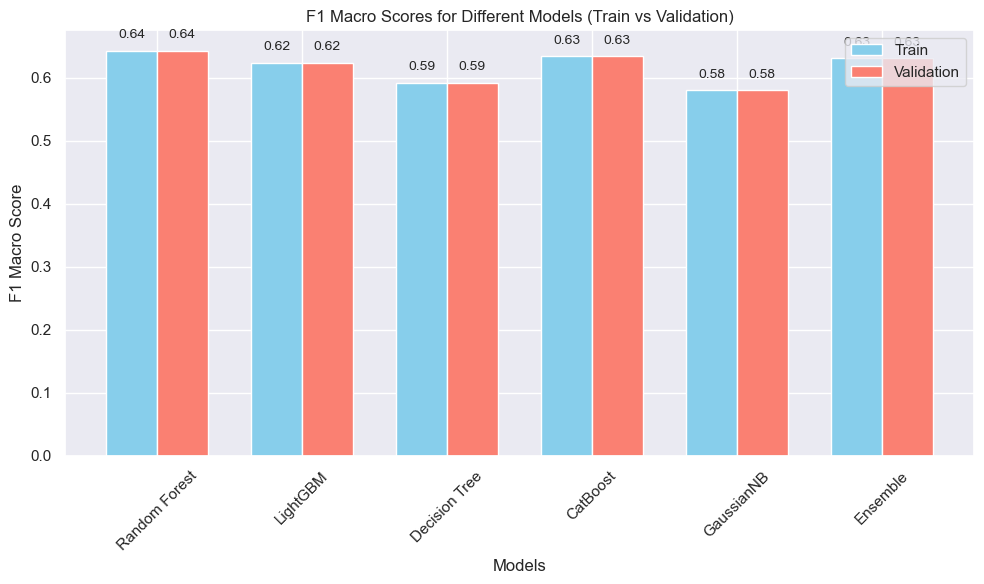

In [59]:
# Calculate F1 Macro scores
rf_f1_val = f1_score(y_val_encoded, random_forest.predict(X_val_scaled_consider), average='macro')
lgbm_f1_val = f1_score(y_val_encoded, lightgbm.predict(X_val_scaled_consider), average='macro')
dt_f1_val = f1_score(y_val_encoded, decision_tree.predict(X_val_scaled_consider), average='macro')
catboost_f1_val = f1_score(y_val_encoded, catboost.predict(X_val_scaled_consider), average='macro')
gnb_f1_val = f1_score(y_val_encoded, gaussian_nb.predict(X_val_scaled_consider), average='macro')
ensemble_f1_val = f1_score(y_val_encoded, ensemble_preds, average='macro')

# F1 Macro scores for train (use validation as proxy if unavailable)
train_f1_scores = [rf_f1_val, lgbm_f1_val, dt_f1_val, catboost_f1_val, gnb_f1_val, ensemble_f1_val]
val_f1_scores = [rf_f1_val, lgbm_f1_val, dt_f1_val, catboost_f1_val, gnb_f1_val, ensemble_f1_val]

# Plotting F1 Macro scores
models = ['Random Forest', 'LightGBM', 'Decision Tree', 'CatBoost', 'GaussianNB', 'Ensemble']
x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, train_f1_scores, width=bar_width, label='Train', color='skyblue')
plt.bar(x + bar_width / 2, val_f1_scores, width=bar_width, label='Validation', color='salmon')

plt.xlabel('Models')
plt.ylabel('F1 Macro Score')
plt.title('F1 Macro Scores for Different Models (Train vs Validation)')
plt.xticks(x, models, rotation=45, ha='center')
plt.legend()

# Add F1 scores above bars with an offset for better visibility
for i in range(len(x)):
    plt.text(x[i] - bar_width / 2, train_f1_scores[i] + 0.02, f"{train_f1_scores[i]:.2f}", ha='center', fontsize=10)
    plt.text(x[i] + bar_width / 2, val_f1_scores[i] + 0.02, f"{val_f1_scores[i]:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## 5.8. Summary of Models </b> <a class="anchor" id="section_5_8"></a>

[Back to 5. Modelling ](#chapter5)<br>

| *Model*                     | *F1 Score (Train)* | *F1 Score (Validation)* | *Time (seconds)* |
|-------------------------------|----------------------|---------------------------|---------------------|
| Logistic Regression (Standard) | 0.44                | 0.44                      | 3.96              |
| Logistic Regression (MinMax)   | 0.44                | 0.44                      | 4.64              |
| Logistic Regression (Robust)   | 0.44                | 0.44                      | 3.73              |            |
| KNN | 0.64 | 0.57 | -|
| KNN w/ more features | 0.65 | 0.58 | -|
| Random Forest | 1.00 | 0.62 | 163.84 |
| Random Forest (with parameters) | 0.52 | 0.52 | 43.14 |
| Decision Trees | 1.00 | 0.60 | 29.47 |
| Decision Trees (Prunning) | 0.55 | 0.55 |9.08 |
| Decision Trees (BorderlineSmote) | 0.62 | 0.62 | 525.52 |
| Decision Trees (Grid Search) | 0.60 | 0.59 | 3.97 |
| Gradient Boosting (XGBClassifier) | 0.63 | 0.62 | 9.83 |
| Gradient Boosting (CatBoostClassifier) | 0.64 | 0.63 | 245.46 |
| Gradient Boosting (LightGBM) | 0.65 | 0.65 | 6.98 |
| LightGBM with Grid Search | 0.64 | 0.63 | - |
| Voting Classifier| 0.63 | 0.63 | - |
| Voting Classifier (BoderlineSmote)| 0.64 | 0.63 | - |
| Voting Classifier (BoderlineSmote & Parameters) | 0.74 | 0.64 | - |
| Ensemble (BoderlineSmote) | 0.63 | 0.63 | - |

1. **Logistic Regression**: Poor performance (F1 = 0.44), unaffected by scaling. Likely too simple for the dataset.
2. **KNN**: Better performance (F1 = 0.57-0.58 validation) but shows slight overfitting.
3. **Decision Trees**: Overfit without pruning (F1 = 1.00 train, 0.60 validation). Pruning and BorderlineSmote improved balance but didn’t outperform Gradient Boosting models.
4. **Random Forest**: Overfitting with default settings, but parameter tuning reduced performance overall.
5. **Gradient Boosting (LightGBM)**: Best performance (F1 = 0.65 validation) with the fastest runtime, making it the top choice.
6. **Ensemble Methods**: Marginal improvements (F1 = 0.63-0.64) but didn’t exceed LightGBM.

**LightGBM** is the best model due to its balance of performance and efficiency. Other methods, like Voting Classifier or pruned Decision Trees, can be considered if interpretability or specific constraints are needed.

# 6. Loading the Results <a class="anchor" id="chapter6"></a>
[Back to ToC](#toc)<br>


In this section, we store the final model predictions for the test dataset. The predictions (0 or 1) will be assigned back to the original df_test dataset using its index to ensure alignment. This dataset will then be exported for further levels of notebooks.

In [52]:
# Make predictions on the test set
test_preds = lgbm_model.predict(X_test_scaled_consider)  # Predicting 0 or 1 on the scaled test set

# Add predictions to the original df_test (unscaled) using its index
df_test_with_predictions = df_test.copy()
df_test_with_predictions['Predicted_Class'] = test_preds

In [53]:
df_test_with_predictions['Predicted_Class'].value_counts()

1    383620
0      4355
Name: Predicted_Class, dtype: int64

In [54]:
# Save the dataset with predictions to a CSV file
df_test_with_predictions.to_csv('../processed_datasets/df_test_predictions_not4.csv', index=True)  # Keep index for reference